# Full shape examples

In this notebook we will show how to perform full shape fits to data power spectrum, using Taylor expansion to speed likelihood evaluation.
Look first at notebooks basic_examples.ipynb to get a flavor of *cosmofit* behaviour, and bao_examples.ipynb for application to BAO fits.

## Fake power spectrum data

In [1]:
import numpy as np
from matplotlib import pyplot as plt

from cosmoprimo.fiducial import DESI

cosmo = DESI()
edges = np.linspace(0., 0.3, 31)
k = (edges[:-1] + edges[1:]) / 2.
nmodes = 4. * np.pi / 3. * (edges[1:]**3 - edges[:-1]**3)
z = 1.
fo = cosmo.get_fourier()
pk = fo.pk_interpolator(of='delta_cb')(k, z=z)
b = 2.
f = fo.sigma8_z(z, of='theta_cb') / fo.sigma8_z(z, of='delta_cb')
shotnoise = 1 / 1e-4
volume = 1e9

ells = (0, 2, 4)
poles = []
poles.append((b**2 + 2. / 3. * f * b + 1. / 5. * f**2) * pk + shotnoise)
poles.append((4. / 3. * f * b + 4. / 7. * f**2) * pk)
poles.append(8. / 35 * f**2 * pk)
poles = np.array(poles, dtype='f8')

from pypower import PowerSpectrumStatistics
mean = PowerSpectrumStatistics(edges, k, poles, nmodes=nmodes, ells=ells, shotnoise_nonorm=shotnoise, statistic='multipole')
cov = [2. * (2. * np.pi)**3 / (2 * ell + 1) / (volume * nmodes) * poles[0]**2 for ell in ells]
cov = np.diag(np.concatenate(cov, axis=0))

rng = np.random.RandomState(seed=42)
mocks = []
for i in range(1000):
    tmp = mean.deepcopy()
    tmp.power_nonorm.flat[...] = rng.multivariate_normal(mean.power_nonorm.ravel(), cov)
    mocks.append(tmp)

## Full likelihood

In [2]:
config = {}
config['like'] = {'class': 'cosmofit.likelihoods.PowerSpectrumMultipolesLikelihood',
                  'init': {'data': mocks, 'covariance': mocks, 'covariance_scale': True,
                           'klim': {0: [0.02, 0.2], 2: [0.02, 0.2]},  # fit monopole and quadrupole, between 0.02 and 0.2 h/Mpc
                           'zeff': z, 'fiducial': 'DESI'}}
# Here we use Kaiser power spectrum for fast calculation,
#  but there is also LPTTracerPowerSpectrumMultipoles based on Velocileptors
config['tracer'] = {'class': 'cosmofit.theories.full_shape.KaiserTracerPowerSpectrumMultipoles',
                    'params': {'b1': {'ref': {'dist': 'uniform', 'limits': [1.95, 2.05]}}},
                               'sn0': {'ref': {'dist': 'uniform', 'limits': [-50., 50.]}}}
                   #'init': {'mu': 50}}  # only 50 mu (instead of 200) to speed up calculation in this notebook
config['cosmo'] = {'class': 'cosmofit.theories.primordial_cosmology.Cosmoprimo'}
config['param'] = {'class': 'cosmofit.theories.power_template.FullPowerSpectrumParameterization',
                   'init': {'fiducial': 'DESI'},
                   'params': {'.fixed': 'n_s',
                              'Omega_m': {'prior': {'dist': 'uniform', 'limits': [0.05, 0.6]},
                                          'ref': {'dist': 'uniform', 'limits': [0.30, 0.33]}, 'latex': '\Omega_{m}'},
                               'A_s': {'prior': {'dist': 'uniform', 'limits': [1.8e-9, 3e-9]},
                                       'ref': {'dist': 'uniform', 'limits': [1.9e-9, 2.1e-9]}},
                               'h': {'prior': {'dist': 'uniform', 'limits': [0.4, 0.9]},
                                     'ref': {'dist': 'uniform', 'limits': [0.65, 0.70]}}}}
    

# NOTE: if we wanted to fit xi instead:
# config['like'] = {'class': 'cosmofit.likelihoods.CorrelationFunctionMultipolesLikelihood',
#                   'init': {'data': data, 'covariance': mocks,
#                            'slim': {0: [40., 160], 2: [40., 160]},  # fit monopole and quadrupole, between 40 and 160 Mpc/h
#                            'zeff': z, 'fiducial': 'DESI'}}
# config['tracer'] = {'class': 'cosmofit.theories.full_shape.KaiserTracerCorrelationFunctionMultipoles'}
# The rest would be the same

from cosmofit import LikelihoodPipeline, setup_logging

setup_logging()

likelihood = LikelihoodPipeline(config)

[000000.00] [0/1] 08-18 18:03  PipelineConfig            INFO     Loading config file /local/home/adematti/Desktop/DESI/NERSC/cosmodesi/cosmofit/cosmofit/likelihoods/power_spectrum.yaml
[000000.08] [0/1] 08-18 18:03  PipelineConfig            INFO     Loading config file /local/home/adematti/Desktop/DESI/NERSC/cosmodesi/cosmofit/cosmofit/theories/full_shape.yaml
[000000.11] [0/1] 08-18 18:03  PipelineConfig            INFO     Loading config file /local/home/adematti/Desktop/DESI/NERSC/cosmodesi/cosmofit/cosmofit/theories/primordial_cosmology.yaml
[000000.12] [0/1] 08-18 18:03  PipelineConfig            INFO     Loading config file /local/home/adematti/Desktop/DESI/NERSC/cosmodesi/cosmofit/cosmofit/theories/power_template.yaml
[000000.52] [0/1] 08-18 18:03  PowerSpectrumMultipolesLikelihood INFO     Covariance matrix with 36 points built from 1000 observations.
[000000.52] [0/1] 08-18 18:03  PowerSpectrumMultipolesLikelihood INFO     ...resulting in Hartlap factor of 0.9630.
[000000.52

In [3]:
#c = likelihood.calculators[3]

#for name in ['Omega0_m', 'Omega0_b', 'A_s', 'n_s', 'k_pivot', 'h', 'Omega0_ncdm']:
#    print(getattr(c.template.cosmo, name) / getattr(cosmo, name))
    
#c.template.cosmo.get_fourier().pk_interpolator(of='delta_cb')(c.template.k, z=z) / cosmo.get_fourier().pk_interpolator(of='delta_cb')(c.template.k, z=z)
#c.power_dd / cosmo.get_fourier().pk_interpolator(of='delta_cb')(c.template.k, z=z)

[000003.20] [0/1] 08-18 18:03  TaylorEmulatorEngine      INFO     Varied parameters: ['sn0', 'b1', 'Omega_m', 'A_s', 'h'].
[000003.20] [0/1] 08-18 18:03  TaylorEmulatorEngine      INFO     Found varying {'power'} and fixed ['k', 'zeff', 'ells', 'fiducial'] outputs.
[000028.80] [0/1] 08-18 18:04  TaylorEmulatorEngine      INFO     Diagnostics:
[000028.84] [0/1] 08-18 18:04  TaylorEmulatorEngine      INFO     - mse of power is 2.82e-05 (square root = 0.00531).
[000029.05] [0/1] 08-18 18:04  TaylorEmulatorEngine      INFO     Saving _tests/kaiser_emulator.npy.
[000029.05] [0/1] 08-18 18:04  TaylorEmulatorEngine      INFO     Saving _tests/kaiser_emulator.yaml.


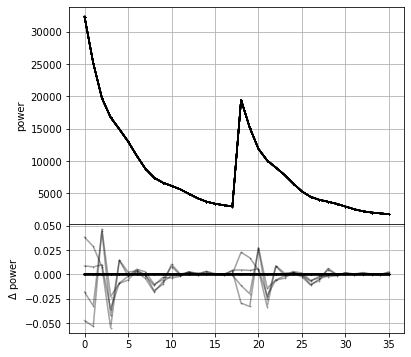

In [4]:
from cosmofit.base import BasePipeline
from cosmofit.emulators import TaylorEmulatorEngine

pipeline = likelihood.select('tracer', type=BasePipeline)
emulator = TaylorEmulatorEngine(pipeline, order={'*': 2, 'sn0': 1})  # order 2 except for sn0 (order 1 is enough)
emulator.set_samples()
emulator.fit()
emulator.check()
emulator.plot(name='power')

import os
base_dir = '_tests'
kaiser_emulator_fn = os.path.join(base_dir, 'kaiser_emulator.npy')
emulator.save(kaiser_emulator_fn)

## Sampling
Let us draw MC samples of the likelihood (actually posterior, including parameter priors).

In [5]:
from cosmofit.samplers import EmceeSampler

config['tracer']['load'] = kaiser_emulator_fn
del config['param'], config['cosmo']
likelihood = LikelihoodPipeline(config)

sampler = EmceeSampler(likelihood, seed=42)
converged = False
while not converged:
    sampler.run(niterations=500)
    converged = sampler.check(eigen_gr_stop=0.03)

[000029.54] [0/1] 08-18 18:04  PipelineConfig            INFO     Loading config file /local/home/adematti/Desktop/DESI/NERSC/cosmodesi/cosmofit/cosmofit/likelihoods/power_spectrum.yaml
[000029.55] [0/1] 08-18 18:04  KaiserTracerPowerSpectrumMultipoles INFO     Loading _tests/kaiser_emulator.npy.
[000029.57] [0/1] 08-18 18:04  PipelineConfig            INFO     Loading config file _tests/kaiser_emulator.yaml
[000029.91] [0/1] 08-18 18:04  PowerSpectrumMultipolesLikelihood INFO     Covariance matrix with 36 points built from 1000 observations.
[000029.91] [0/1] 08-18 18:04  PowerSpectrumMultipolesLikelihood INFO     ...resulting in Hartlap factor of 0.9630.
[000029.91] [0/1] 08-18 18:04  PipelineConfig            INFO     Loading config file /local/home/adematti/Desktop/DESI/NERSC/cosmodesi/cosmofit/cosmofit/theories/base.yaml
[000029.92] [0/1] 08-18 18:04  PipelineConfig            INFO     No config for WindowedPowerSpectrumMultipoles found in config file /local/home/adematti/Desktop/

[000084.67] [0/1] 08-18 18:05  EmceeSampler              INFO     - max eigen Gelman-Rubin - 1 is 0.36 > 0.03.
[000084.71] [0/1] 08-18 18:05  EmceeSampler              INFO     - max diag Gelman-Rubin - 1 is 0.292.
[000084.83] [0/1] 08-18 18:05  EmceeSampler              INFO     - max diag Gelman-Rubin - 1 at 1.0 sigmas is 0.376.
[000084.84] [0/1] 08-18 18:05  EmceeSampler              INFO     - max Geweke is 0.553.
[000084.89] [0/1] 08-18 18:05  EmceeSampler              INFO     - max integrated autocorrelation time is 144.
[000084.89] [0/1] 08-18 18:05  EmceeSampler              INFO     - max variation of integrated autocorrelation time is 0.0357.
[000090.09] [0/1] 08-18 18:05  EmceeSampler              INFO     Diagnostics:
[000090.12] [0/1] 08-18 18:05  EmceeSampler              INFO     - max eigen Gelman-Rubin - 1 is 0.283 > 0.03.
[000090.16] [0/1] 08-18 18:05  EmceeSampler              INFO     - max diag Gelman-Rubin - 1 is 0.235.
[000090.30] [0/1] 08-18 18:05  EmceeSampler

[000145.47] [0/1] 08-18 18:06  EmceeSampler              INFO     - max diag Gelman-Rubin - 1 is 0.099.
[000145.63] [0/1] 08-18 18:06  EmceeSampler              INFO     - max diag Gelman-Rubin - 1 at 1.0 sigmas is 0.0474.
[000145.64] [0/1] 08-18 18:06  EmceeSampler              INFO     - max Geweke is 0.986.
[000145.70] [0/1] 08-18 18:06  EmceeSampler              INFO     - max integrated autocorrelation time is 136 (reliable).
[000145.71] [0/1] 08-18 18:06  EmceeSampler              INFO     - max variation of integrated autocorrelation time is 0.0107.
[000150.88] [0/1] 08-18 18:06  EmceeSampler              INFO     Diagnostics:
[000150.91] [0/1] 08-18 18:06  EmceeSampler              INFO     - max eigen Gelman-Rubin - 1 is 0.115 > 0.03.
[000150.96] [0/1] 08-18 18:06  EmceeSampler              INFO     - max diag Gelman-Rubin - 1 is 0.0926.
[000151.12] [0/1] 08-18 18:06  EmceeSampler              INFO     - max diag Gelman-Rubin - 1 at 1.0 sigmas is 0.0357.
[000151.14] [0/1] 08-1

[000206.78] [0/1] 08-18 18:07  EmceeSampler              INFO     - max diag Gelman-Rubin - 1 is 0.0441.
[000206.99] [0/1] 08-18 18:07  EmceeSampler              INFO     - max diag Gelman-Rubin - 1 at 1.0 sigmas is 0.0275.
[000207.00] [0/1] 08-18 18:07  EmceeSampler              INFO     - max Geweke is 0.641.
[000207.11] [0/1] 08-18 18:07  EmceeSampler              INFO     - max integrated autocorrelation time is 119 (reliable).
[000207.11] [0/1] 08-18 18:07  EmceeSampler              INFO     - max variation of integrated autocorrelation time is 0.0185.
[000212.33] [0/1] 08-18 18:07  EmceeSampler              INFO     Diagnostics:
[000212.37] [0/1] 08-18 18:07  EmceeSampler              INFO     - max eigen Gelman-Rubin - 1 is 0.0564 > 0.03.
[000212.43] [0/1] 08-18 18:07  EmceeSampler              INFO     - max diag Gelman-Rubin - 1 is 0.0441.
[000212.64] [0/1] 08-18 18:07  EmceeSampler              INFO     - max diag Gelman-Rubin - 1 at 1.0 sigmas is 0.0242.
[000212.65] [0/1] 08

[000268.95] [0/1] 08-18 18:08  EmceeSampler              INFO     - max eigen Gelman-Rubin - 1 is 0.0346 > 0.03.
[000268.99] [0/1] 08-18 18:08  EmceeSampler              INFO     - max diag Gelman-Rubin - 1 is 0.0217.
[000269.22] [0/1] 08-18 18:08  EmceeSampler              INFO     - max diag Gelman-Rubin - 1 at 1.0 sigmas is 0.014.
[000269.25] [0/1] 08-18 18:08  EmceeSampler              INFO     - max Geweke is 0.512.
[000269.42] [0/1] 08-18 18:08  EmceeSampler              INFO     - max integrated autocorrelation time is 113 (reliable).
[000269.42] [0/1] 08-18 18:08  EmceeSampler              INFO     - max variation of integrated autocorrelation time is 0.0143.
[000274.62] [0/1] 08-18 18:08  EmceeSampler              INFO     Diagnostics:
[000274.67] [0/1] 08-18 18:08  EmceeSampler              INFO     - max eigen Gelman-Rubin - 1 is 0.0326 > 0.03.
[000274.71] [0/1] 08-18 18:08  EmceeSampler              INFO     - max diag Gelman-Rubin - 1 is 0.0205.
[000274.94] [0/1] 08-18 18:

[000332.86] [0/1] 08-18 18:09  EmceeSampler              INFO     Diagnostics:
[000332.93] [0/1] 08-18 18:09  EmceeSampler              INFO     - max eigen Gelman-Rubin - 1 is 0.0325 > 0.03.
[000332.97] [0/1] 08-18 18:09  EmceeSampler              INFO     - max diag Gelman-Rubin - 1 is 0.0185.
[000333.26] [0/1] 08-18 18:09  EmceeSampler              INFO     - max diag Gelman-Rubin - 1 at 1.0 sigmas is 0.0117.
[000333.29] [0/1] 08-18 18:09  EmceeSampler              INFO     - max Geweke is 0.382.
[000333.57] [0/1] 08-18 18:09  EmceeSampler              INFO     - max integrated autocorrelation time is 105 (reliable).
[000333.57] [0/1] 08-18 18:09  EmceeSampler              INFO     - max variation of integrated autocorrelation time is 0.0104.
[000338.85] [0/1] 08-18 18:09  EmceeSampler              INFO     Diagnostics:
[000338.90] [0/1] 08-18 18:09  EmceeSampler              INFO     - max eigen Gelman-Rubin - 1 is 0.0332 > 0.03.
[000338.98] [0/1] 08-18 18:09  EmceeSampler         

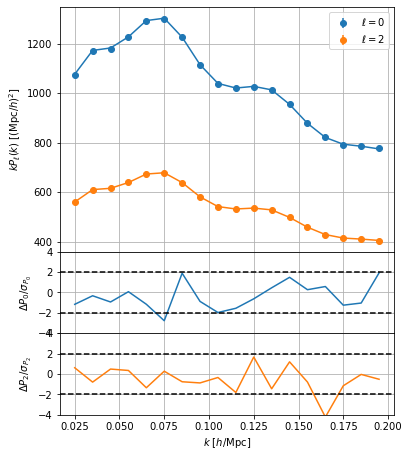

In [9]:
likelihood.end_calculators[0].plot()
plt.show()

In [10]:
chain = sampler.chains[0].remove_burnin(0.5)
print(chain.to_stats(tablefmt='pretty'))

+---------+-----------+-----------+-----------+---------+-------------------+-------------------+
|         |  argmax   |   mean    |  median   |   std   |  quantile:1sigma  |  interval:1sigma  |
+---------+-----------+-----------+-----------+---------+-------------------+-------------------+
|   sn0   |    -5     |    -6     |    -5     |   20.   |     -5.8/+6.5     |     -5.8/+6.5     |
| Omega_m |  0.3161   |  0.3159   |  0.3160   | 0.0010  |  -8.7e-4/+8.7e-4  |  -7.5e-4/+9.7e-4  |
|   A_s   | 2.0964e-9 | 2.0943e-9 | 2.0950e-9 | 8.8e-12 | -7.3e-12/+7.8e-12 | -6.2e-12/+8.7e-12 |
|    h    |  0.6720   |  0.6723   |  0.6722   | 0.0011  |  -9.8e-4/+9.1e-4  | -0.00112/+0.00075 |
|   b1    |  1.9988   |  1.9989   |  1.9990   | 0.0023  |  -0.0019/+0.0020  |  -0.0019/+0.0021  |
+---------+-----------+-----------+-----------+---------+-------------------+-------------------+


Removed no burn in
[000389.73] [0/1] 08-18 18:10  root                      WARNING  fine_bins not large enough to well sample smoothing scale - sn0
[000390.35] [0/1] 08-18 18:10  root                      WARNING  fine_bins_2D not large enough for optimal density: sn0, Omega_m
[000390.64] [0/1] 08-18 18:10  root                      WARNING  fine_bins_2D not large enough for optimal density: sn0, h
[000390.80] [0/1] 08-18 18:10  root                      WARNING  fine_bins_2D not large enough for optimal density: sn0, b1
[000390.96] [0/1] 08-18 18:10  root                      WARNING  fine_bins_2D not large enough for optimal density: Omega_m, A_s
[000391.10] [0/1] 08-18 18:10  root                      WARNING  fine_bins_2D not large enough for optimal density: Omega_m, h
[000391.26] [0/1] 08-18 18:10  root                      WARNING  fine_bins_2D not large enough for optimal density: Omega_m, b1
[000391.67] [0/1] 08-18 18:10  root                      WARNING  fine_bins_2D not la

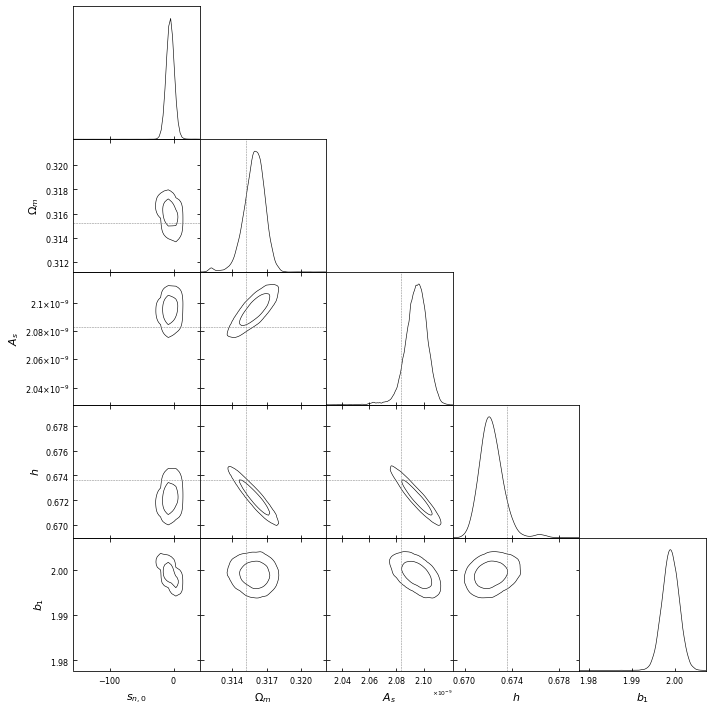

In [11]:
from cosmofit.samples import plotting
plotting.plot_triangle(chain, markers={'Omega_m': cosmo.Omega0_m, 'h': cosmo.h, 'A_s': cosmo.A_s, 'n_s': cosmo.n_s, 'b1': b, 'sn0': 0.})